In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='serif')
from astropy.io import fits, ascii
from astropy.table import Table
import os
import math

import TheCannon
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2016/bin/x86_64-darwin'

In [2]:
dfile = AP_PATH + '/cannon_sets/mann_sample/'
rfile = 'samples/mann_x_apogee.csv' 
tr_label = ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H'])
tr_label_unc = ap.loadLabels(rfile, lbl_names=['E_TEFF', 'E_FE_H'])
ds = ap.initializeTrainingSet(data=dfile, ref=rfile, lbl_names=['TEFF', 'FE_H'], save_base='mann')

This is the right version
Loading spectra from directory /Users/Jessica/Desktop/Research/apogee_data/cannon_sets/mann_sample/
Spectra loaded
Loading dataset
Loaded /Users/Jessica/Desktop/Research/apogee_data/cannon_sets/norm_fluxes/mann_norm_tr_flux.npy
Loaded /Users/Jessica/Desktop/Research/apogee_data/cannon_sets/norm_fluxes/mann_norm_tr_ivar.npy


In [3]:
md, synth_fluxes, test_labels = ap.runCannon(ds)

Done training model. 
Inferring Labels


In [5]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


In [5]:
trn_labels, crv_labels = ap.crossValidate(ds, lbl_names=['TEFF', 'FE_H'])

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [0/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [1/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [2/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [3/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [4/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [5/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [6/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [7/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [8/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [9/30] sources.

Loading dataset
Done training 

In [10]:
np.save('mann_results/trn_labels.npy', trn_labels)
np.save('mann_results/crv_labels.npy', crv_labels)

In [2]:
trn_labels = np.load('mann_results/trn_labels.npy')
crv_labels = np.load('mann_results/crv_labels.npy')

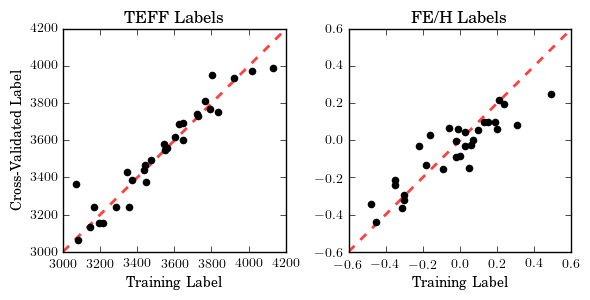

In [7]:
ap.plotCrossValidation(trn_labels, crv_labels, save=True, label_names=['TEFF', 'FE/H'], out='mann_results/mann_cross_validation.pdf')

In [49]:
def plotCannonModels(ds, te_flux, te_labels, **kwargs):

    nspecs = len(te_flux)
    bands  = [[15160,15800],[15880,16420],[16500,16935]]
    n      = kwargs.get('band', 1)
    yrange = kwargs.get('yrange', [.6,1.2])
    lbl_names = kwargs.get('lbl_names', ['TEFF', 'FE/H'])
    snr = kwargs.get('snr', [])
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Models_Band'+str(n)+'.pdf')
    
    tr_label = ds.tr_label
    tr_label_unc = kwargs.get('tr_lbl_unc')
    te_label = te_labels
    te_label_unc = kwargs.get('te_lbl_unc', [0,0])
    
    wl = ds.wl
    tr_flux = ds.tr_flux
    tr_ivar = ds.tr_ivar
    
    fig, axs = plt.subplots(nspecs, 1, figsize=(12,3*nspecs))
    for i, ax in enumerate(fig.axes):

        tr_stdev = [1/math.sqrt(ivar) for ivar in tr_ivar[i]]
    
        data = ap.Spectrum(wave=wl, flux=tr_flux[i], sigmas=tr_stdev)
        mdl  = ap.Spectrum(wave=wl, flux=te_flux[i])
        chi  = ap.compareSpectra(data, mdl, fit_scale=False)[0]
        
        ax.plot(wl, tr_flux[i], color='k')
        ax.plot(wl, te_flux[i], color='r')
        
        cannon_lbl = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(te_label[i][0],-1), te_label_unc[0], round(te_label[i][1],2), te_label_unc[1]) 
        ax.text(bands[n-1][0]+10, yrange[1]-.08, cannon_lbl,color='r', fontsize=15, va='bottom', ha='left')
        
        ref_lbl = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(tr_label[i][0],-1), tr_label_unc[i][0], round(tr_label[i][1],2), tr_label_unc[i][1]) 
        ax.text(bands[n-1][0]+10, yrange[0]+.08, ref_lbl, color='k', fontsize=15, va='top', ha='left')
        
        chi_lbl = r'$\chi^{2} = %s$'%(str(chi))
        ax.text(bands[n-1][1]-10, yrange[1]-.08, chi_lbl, color='r', fontsize=15, va='bottom', ha='right')
        
        if len(snr) != 0:
            snr_lbl = r'$SNR = {}$'.format(str(snr[i]))
            ax.text(bands[n-1][1]-10, yrange[0]+.08, snr_lbl, color='k', fontsize=15, va='top', ha='right')
         
        ax.set_title(r'${}$'.format(ds.tr_ID[i]), fontsize=20)
        ax.set_xlim(bands[n-1])
        ax.set_ylim(yrange)
        ax.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=15)
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=15)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()

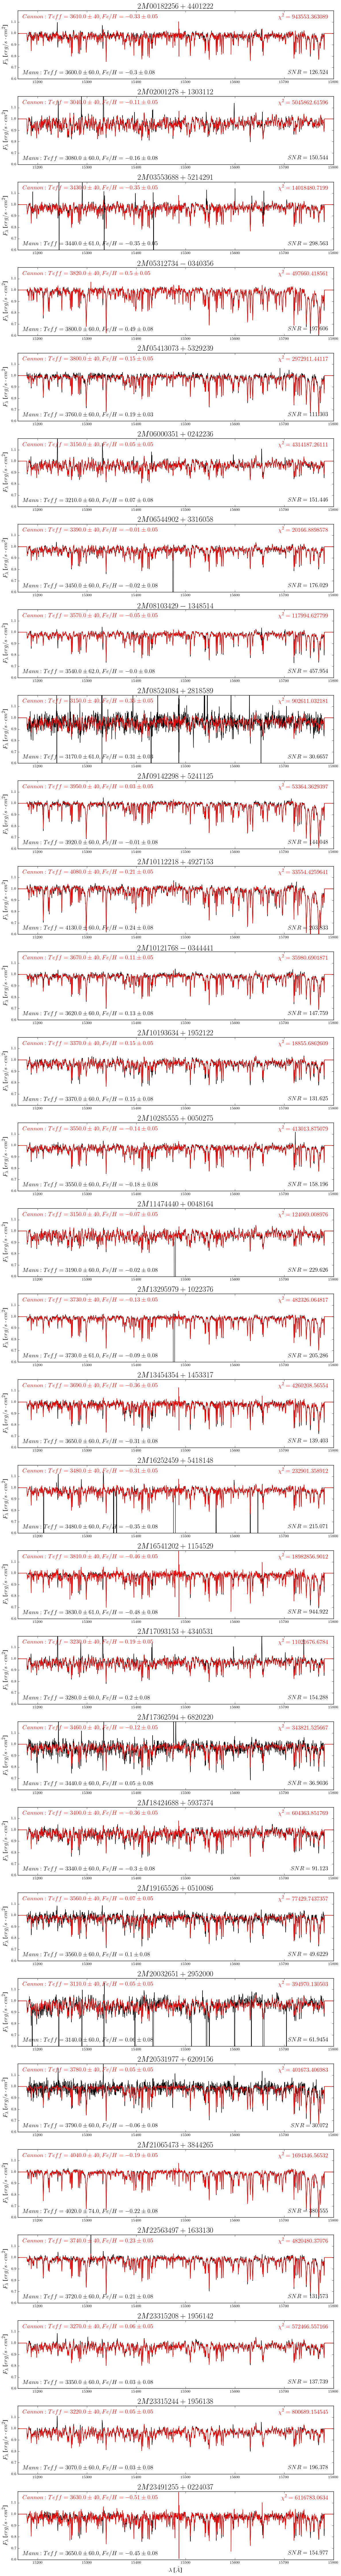

In [50]:
n = 1
snr = pd.read_csv(rfile)['SNR']
plotCannonModels(ds, synth_fluxes, test_labels, save=True, out='mann_results/Models_Band'+str(n)+'.pdf', \
                 tr_lbl_unc=tr_label_unc, te_lbl_unc=[40,.05], snr=snr, band=n)

In [51]:
data = ap.Spectrum(wave=ds.wl, flux=ds.tr_flux[0])
data.mask(sigma=[.5,.5])

/Users/Jessica/Desktop/astro_code/apogee_tools/apogee_tools/core.py:398: RuntimeWarning: invalid value encountered in less_equal
  cut_low  = np.where(self.flux <= fmean - sigma[0]*fstd)[0]
/Users/Jessica/Desktop/astro_code/apogee_tools/apogee_tools/core.py:399: RuntimeWarning: invalid value encountered in greater_equal
  cut_high = np.where(self.flux >= fmean + sigma[1]*fstd)[0]


In [34]:
ds.tr_ID

['2M00182256+4401222',
 '2M02001278+1303112',
 '2M03553688+5214291',
 '2M05312734-0340356',
 '2M05413073+5329239',
 '2M06000351+0242236',
 '2M06544902+3316058',
 '2M08103429-1348514',
 '2M08524084+2818589',
 '2M09142298+5241125',
 '2M10112218+4927153',
 '2M10121768-0344441',
 '2M10193634+1952122',
 '2M10285555+0050275',
 '2M11474440+0048164',
 '2M13295979+1022376',
 '2M13454354+1453317',
 '2M16252459+5418148',
 '2M16541202+1154529',
 '2M17093153+4340531',
 '2M17362594+6820220',
 '2M18424688+5937374',
 '2M19165526+0510086',
 '2M20032651+2952000',
 '2M20531977+6209156',
 '2M21065473+3844265',
 '2M22563497+1633130',
 '2M23315208+1956142',
 '2M23315244+1956138',
 '2M23491255+0224037']